In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Bidirectional, GRU, Dropout
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
# Load Data
df_train = pd.read_csv("../input/twitter-sentiment-analysis/twitter_training.csv", header=None)
df_valid = pd.read_csv("../input/twitter-sentiment-analysis/twitter_validation.csv", header=None)

df_train.columns = ['tweet_id', 'entity', 'sentiment', 'tweet']
df_valid.columns = ['tweet_id', 'entity', 'sentiment', 'tweet']

print("Data Loaded Successfully! Train Data Sample:")
print(df_train.head())
print("Validation Data Sample:")
print(df_valid.head())

Data Loaded Successfully! Train Data Sample:
   tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                               tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
Validation Data Sample:
   tweet_id     entity   sentiment  \
0      3364   Facebook  Irrelevant   
1       352     Amazon     Neutral   
2      8312  Microsoft    Negative   
3      4371      CS-GO    Negative   
4      4433     Google     Neutral   

                                               tweet  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Be

In [3]:
# Preprocessing Function
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.replace(r"[^a-zA-Z0-9 ]", "")
        return text
    return ""

df_train['tweet'] = df_train['tweet'].apply(preprocess_text)
df_valid['tweet'] = df_valid['tweet'].apply(preprocess_text)

print("Text Preprocessing Completed! Processed Train Data Sample:")
print(df_train.head())

Text Preprocessing Completed! Processed Train Data Sample:
   tweet_id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                               tweet  
0  im getting on borderlands and i will murder yo...  
1  i am coming to the borders and i will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


In [4]:
# Label Encoding
label_encoder = LabelEncoder()
df_train['sentiment'] = label_encoder.fit_transform(df_train['sentiment'])
df_valid['sentiment'] = label_encoder.transform(df_valid['sentiment'])
print("Label Encoding Completed! Classes:", label_encoder.classes_)

# Tokenization
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['tweet'])
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['tweet']), maxlen=max_len)
X_valid = pad_sequences(tokenizer.texts_to_sequences(df_valid['tweet']), maxlen=max_len)
y_train = df_train['sentiment'].values
y_valid = df_valid['sentiment'].values
print("Tokenization Completed! Vocabulary Size:", len(tokenizer.word_index))

# Hyperparameters
epochs = 5
batch_size = 64
learning_rate = 0.001

Label Encoding Completed! Classes: ['Irrelevant' 'Negative' 'Neutral' 'Positive']
Tokenization Completed! Vocabulary Size: 33784


In [5]:
# ================= LSTM Model ================= #
print("Training LSTM Model...")
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))
print("LSTM Model Training Completed!")

# ================= CNN Model ================= #
print("Training CNN Model...")
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
history_cnn = cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))
print("CNN Model Training Completed!")

# ================= GRU Model ================= #
print("Training GRU Model...")
gru_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(GRU(64)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

gru_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=['accuracy'])
history_gru = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))
print("GRU Model Training Completed!")

Training LSTM Model...
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1167/1167 ━━━━━━━━━━━━━━━━━━━━ 281s 231ms/step - accuracy: 0.5023 - loss: 1.1426 - val_accuracy: 0.8330 - val_loss: 0.4784
Epoch 2/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 274s 235ms/step - accuracy: 0.7724 - loss: 0.6342 - val_accuracy: 0.9110 - val_loss: 0.3272
Epoch 3/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 278s 239ms/step - accuracy: 0.8416 - loss: 0.4472 - val_accuracy: 0.9100 - val_loss: 0.3061
Epoch 4/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 282s 241ms/step - accuracy: 0.8742 - loss: 0.3473 - val_accuracy: 0.9200 - val_loss: 0.3057
Epoch 5/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 281s 241ms/step - accuracy: 0.8966 - loss: 0.2829 - val_accuracy: 0.9330 - val_loss: 0.3091
LSTM Model Training Completed!
Training CNN Model...
Epoch 1/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5117 - loss: 1.1183 - val_accuracy: 0.9050 - val_loss: 0.3208
Epoch 2/5
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8313 - loss: 0.4739 - val_accuracy: 0.9510 - val_loss: 0.1510
Epoch 3/5
1167/1167 ━━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Classification Report for LSTM:
              precision    recall  f1-score   support

  Irrelevant       0.93      0.92      0.92       172
    Negative       0.95      0.95      0.95       266
     Neutral       0.96      0.90      0.93       285
    Positive       0.90      0.95      0.93       277

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Precision for LSTM: 0.9338
Recall for LSTM: 0.9330
F1 Score for LSTM: 0.9330


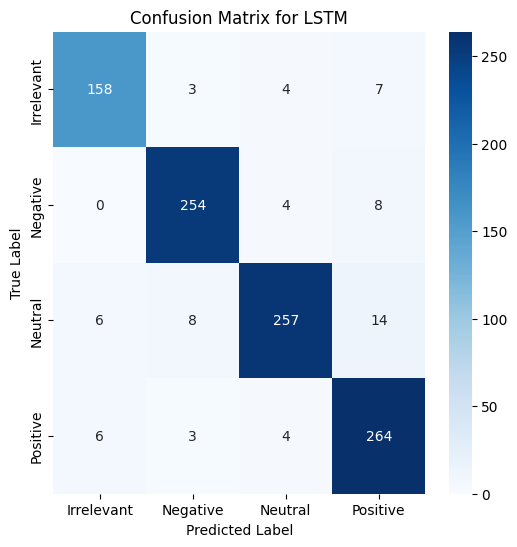

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report for CNN:
              precision    recall  f1-score   support

  Irrelevant       0.95      0.98      0.96       172
    Negative       0.98      0.97      0.98       266
     Neutral       0.96      0.95      0.96       285
    Positive       0.97      0.97      0.97       277

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Precision for CNN: 0.9681
Recall for CNN: 0.9680
F1 Score for CNN: 0.9680


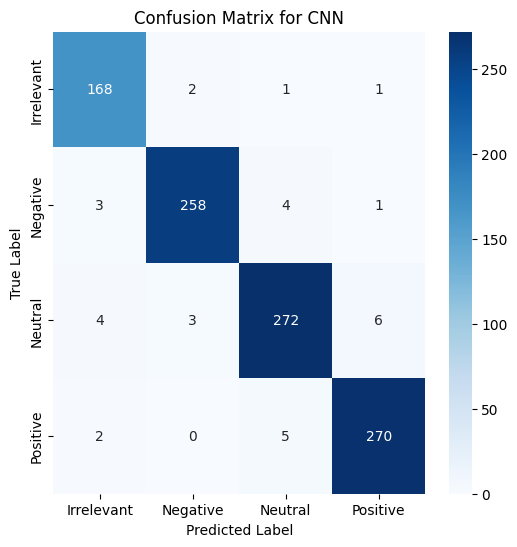

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
Classification Report for GRU:
              precision    recall  f1-score   support

  Irrelevant       0.91      0.92      0.92       172
    Negative       0.94      0.95      0.95       266
     Neutral       0.94      0.94      0.94       285
    Positive       0.92      0.90      0.91       277

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Precision for GRU: 0.9279
Recall for GRU: 0.9280
F1 Score for GRU: 0.9279


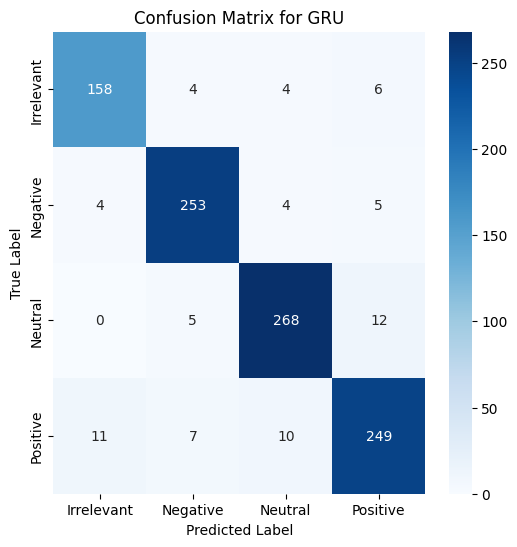

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# ================= Evaluation & Visualization ================= #
def plot_history(histories):
    plt.figure(figsize=(12, 6))
    for model_name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f"{model_name} Train Acc")
        plt.plot(history.history['val_accuracy'], label=f"{model_name} Val Acc")
    plt.title("Model Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

def evaluate_model(model, X_valid, y_valid, model_name):
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    cm = confusion_matrix(y_valid, y_pred)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_valid, y_pred, target_names=label_encoder.classes_))
    
    # Calculate precision, recall, F1-score
    precision = precision_score(y_valid, y_pred, average='weighted')
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')
    
    print(f"Precision for {model_name}: {precision:.4f}")
    print(f"Recall for {model_name}: {recall:.4f}")
    print(f"F1 Score for {model_name}: {f1:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(cm, label_encoder.classes_, title=f"Confusion Matrix for {model_name}")
    
    return precision, recall, f1

# Store metrics after evaluation
metrics = {
    "LSTM": evaluate_model(lstm_model, X_valid, y_valid, "LSTM"),
    "CNN": evaluate_model(cnn_model, X_valid, y_valid, "CNN"),
    "GRU": evaluate_model(gru_model, X_valid, y_valid, "GRU"),
}

# Plot Accuracy, Precision, Recall, F1 Score Comparison
def plot_comparison(metrics):
    labels = list(metrics.keys())
    precision = [metrics[model][0] for model in labels]
    recall = [metrics[model][1] for model in labels]
    f1 = [metrics[model][2] for model in labels]

    x = np.arange(len(labels))

    fig, axes = plt.subplots(3, 1, figsize=(8, 12))

    # Function to add values on bars
    def add_values(ax, bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',  
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, -15 if height > 0.9 else 5),  # Adjust position dynamically
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, fontweight='bold',
                        color='black' if height < 0.9 else 'white')  # Contrast text for visibility

    # Precision Plot
    bars = axes[0].bar(x, precision, color='blue', alpha=0.7)
    add_values(axes[0], bars)
    axes[0].set_title("Precision Comparison")
    axes[0].set_ylabel("Precision Score")
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].set_yticks(np.arange(0, 1.05, 0.05))  # Y-axis increments of 0.05
    axes[0].set_ylim(0, 1)  # Ensure values stay within graph

    # Recall Plot
    bars = axes[1].bar(x, recall, color='green', alpha=0.7)
    add_values(axes[1], bars)
    axes[1].set_title("Recall Comparison")
    axes[1].set_ylabel("Recall Score")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(labels)
    axes[1].set_yticks(np.arange(0, 1.05, 0.05))
    axes[1].set_ylim(0, 1)

    # F1 Score Plot
    bars = axes[2].bar(x, f1, color='red', alpha=0.7)
    add_values(axes[2], bars)
    axes[2].set_title("F1 Score Comparison")
    axes[2].set_ylabel("F1 Score")
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].set_yticks(np.arange(0, 1.05, 0.05))
    axes[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
1167/1167 [==============================] - 853s 713ms/step - loss: 0.8352 - accuracy: 0.6692 - val_loss: 0.3005 - val_accuracy: 0.8950
Epoch 2/5
1167/1167 [==============================] - 829s 711ms/step - loss: 0.3457 - accuracy: 0.8728 - val_loss: 0.1888 - val_accuracy: 0.9470
Epoch 3/5
1167/1167 [==============================] - 830s 711ms/step - loss: 0.1687 - accuracy: 0.9364 - val_loss: 0.1414 - val_accuracy: 0.9640
Epoch 4/5
1167/1167 [==============================] - 830s 711ms/step - loss: 0.1201 - accuracy: 0.9520 - val_loss: 0.1697 - val_accuracy: 0.9570
Epoch 5/5
32/32 [==============================] - 7s 134ms/step
Classification Report for BERT:
              precision    recall  f1-score   support

  Irrelevant       0.98      0.94      0.96       172
    Negative       0.98      0.97      0.98       266
     Neutral       0.96      0.94      0.95       285
    Positive       0.93      0.98      0.95       277

    accuracy                           0.96

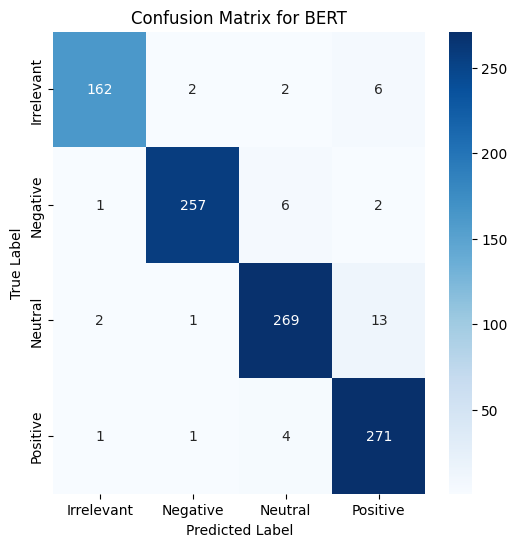

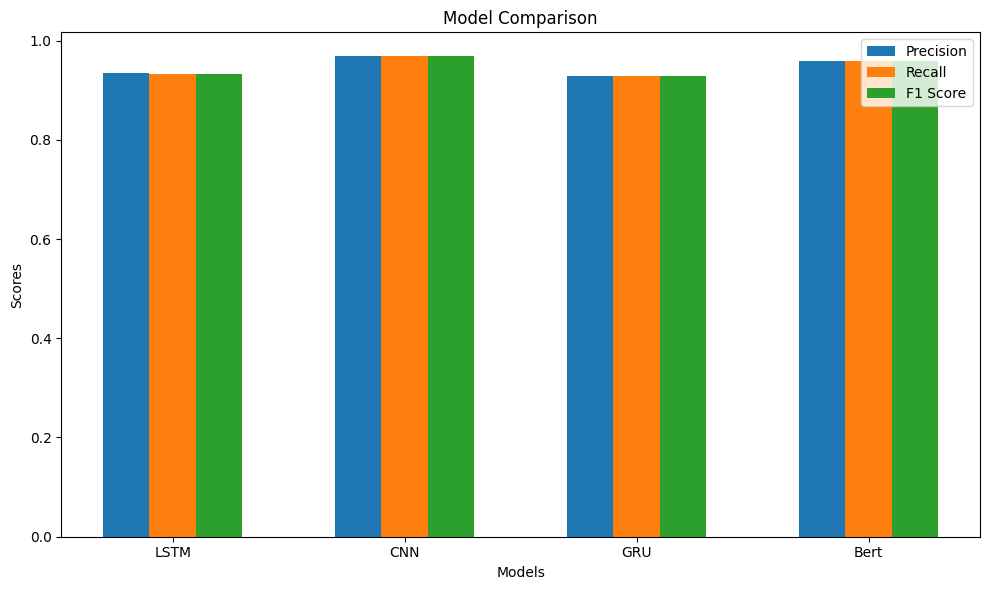

In [7]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model_name = "bert-base-uncased"  # You can replace with "bert-base-uncased" or another transformer model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the text data
def tokenize_data(texts, tokenizer, max_length=100):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

train_encodings = tokenize_data(df_train['tweet'], tokenizer)
valid_encodings = tokenize_data(df_valid['tweet'], tokenizer)

X_train_tf = {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}
X_valid_tf = {'input_ids': valid_encodings['input_ids'], 'attention_mask': valid_encodings['attention_mask']}

num_classes = len(label_encoder.classes_)

transformer_model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes
)

from transformers import AdamWeightDecay  # Use Hugging Face's optimizer

# Use Hugging Face's AdamW optimizer
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

transformer_model.compile(
    optimizer=optimizer,  # Use Hugging Face's optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


history_transformer = transformer_model.fit(
    X_train_tf, y_train,
    validation_data=(X_valid_tf, y_valid),
    epochs=5,
    batch_size=64
)


32/32 [==============================] - 4s 134ms/step
Classification Report for BERT:
              precision    recall  f1-score   support

  Irrelevant       0.98      0.94      0.96       172
    Negative       0.98      0.97      0.98       266
     Neutral       0.96      0.94      0.95       285
    Positive       0.93      0.98      0.95       277

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Precision: 0.9597
Recall: 0.9590
F1 Score: 0.9591


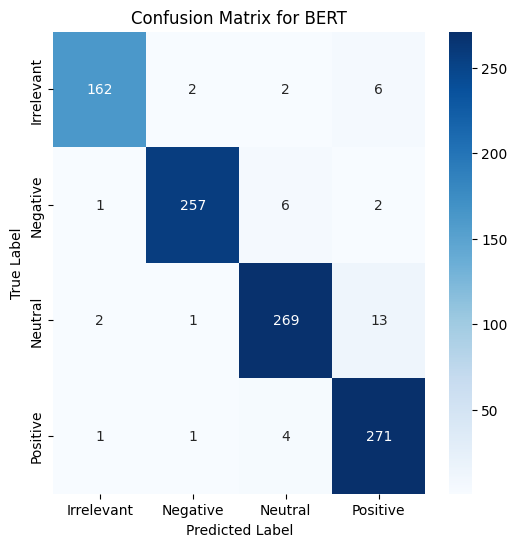

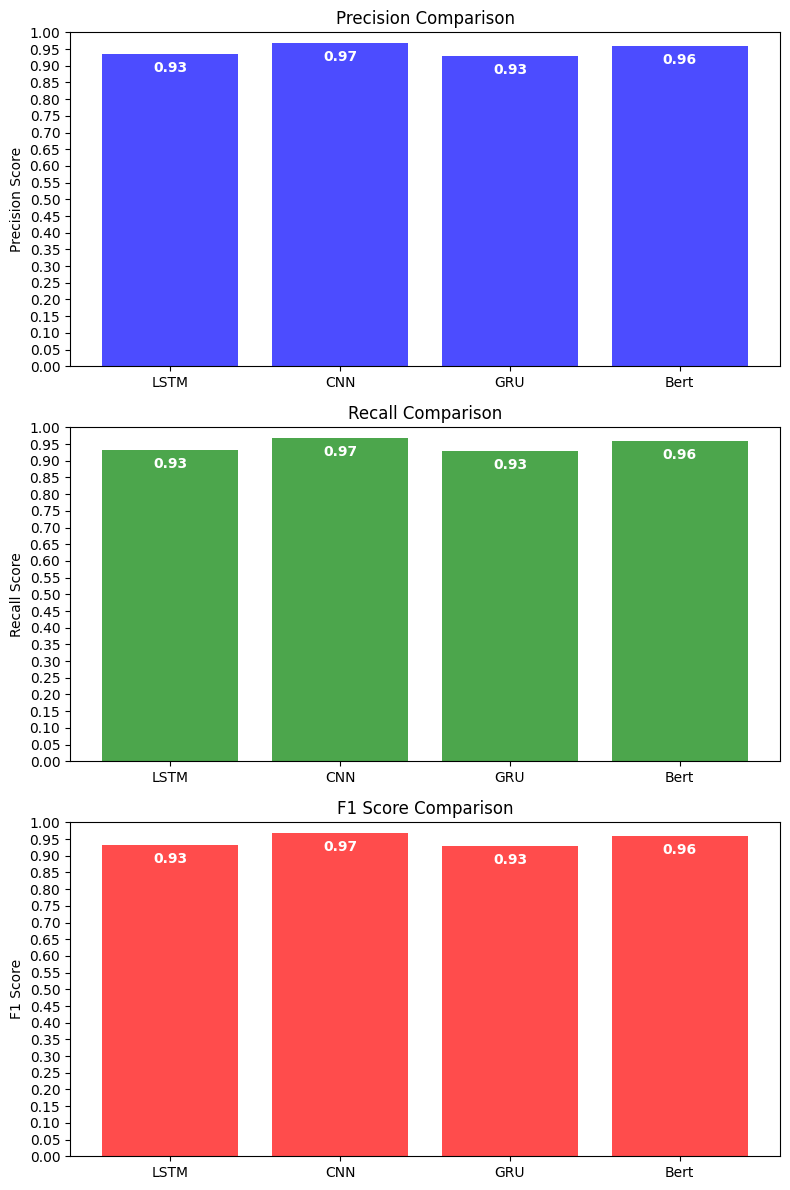

In [23]:
def evaluate_transformer(model, X_valid, y_valid):
    y_pred = np.argmax(model.predict(X_valid).logits, axis=1)
    cm = confusion_matrix(y_valid, y_pred)
    
    print("Classification Report for BERT:")
    print(classification_report(y_valid, y_pred, target_names=label_encoder.classes_))

    precision = precision_score(y_valid, y_pred, average='weighted')
    recall = recall_score(y_valid, y_pred, average='weighted')
    f1 = f1_score(y_valid, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plot_confusion_matrix(cm, label_encoder.classes_, title="Confusion Matrix for BERT")

    return precision, recall, f1

# Evaluate Transformer Model
metrics["Bert"] = evaluate_transformer(transformer_model, X_valid_tf, y_valid)

# Plot comparison of all models
plot_comparison(metrics)